#### SEP 786 PROJECT

#### Read the csv file into a pandas dataframe and then take a sample of 1200

In [39]:
import pandas as p
import numpy as np
from sklearn.linear_model import LogisticRegression
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


data = pd.read_csv('datatraining.txt')
data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [40]:
#remove date
data = data.drop('date', axis =1)
data.head(2)



,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,1
2,23.15,27.2675,429.5,714.00,0.004783,1


In [41]:
#Sample the full data set, take 1000 samples 

data = data.sample(1000,random_state = 1).reset_index(drop=True)

#create a copy which will be used for SBS
data_2 = data.copy()

#check the distribution of labels in the sample
data['Occupancy'].value_counts()

0    786
1    214
Name: Occupancy, dtype: int64

#### Scale Data

In [42]:
minim = data.min(axis = 0)
maxim = data.max(axis = 0)

data = (data - minim)/(maxim - minim)
labels = data['Occupancy']

##### Logistic Regression - PCA for dimensionality Reduction

In [43]:
#substract the mean
means = data.iloc[:,:5].mean()
std_data = data.iloc[:,:5] - means

In [44]:
#compute the eigen vectors and their corresponding eigen values 
eigen_values, eigen_vectors = np.linalg.eig(np.dot(std_data.T, std_data))
eigen_values

array([1.29181879e+02, 8.24495660e+01, 1.27969294e+01, 4.44887160e-02,
       6.54902121e+00])

In [45]:
eigen_vectors

array([[-0.2318063 ,  0.78153985, -0.55254521, -0.17335323,  0.0101859 ],
       [-0.59851974, -0.42626109, -0.15188916, -0.64562188, -0.14204811],
       [-0.17431552,  0.30077983,  0.47450671,  0.02919195, -0.8081688 ],
       [-0.43566084,  0.29367491,  0.62852061, -0.06329516,  0.57000898],
       [-0.60650943, -0.17545224, -0.22677896,  0.74044756, -0.04088443]])

In [46]:
#get the index of the eigen values in decreasing order
sorted_indices = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_indices]
sorted_eigenvectors = eigen_vectors[:,sorted_indices]

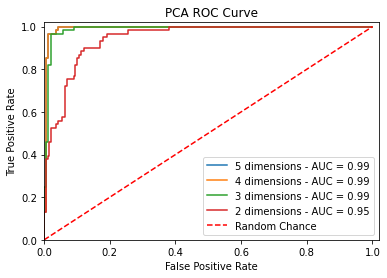

In [47]:
k=5
while k >= 2:
    k_str = str(k) + ' dimensions'
    #recast the data along the principal components
    new_data = np.dot(std_data,sorted_eigenvectors[:,:k])
    #split data into training and testing set ( 75% for training and 25% for testing)
    x_train,x_test,y_train,y_test = train_test_split(new_data,labels,test_size = 0.25, random_state = 10)
    lr = LogisticRegression()
    lr.fit(x_train,y_train)
    predicted_labels = lr.predict(x_test)
    #find scores which will be used for roc curve
    lr_scores_pca = lr.predict_proba(x_test) 
    #find tpr & fpr 
    fpr_pca, tpr_pca, threshold = roc_curve(y_test, lr_scores_pca[:, 1])
    roc_auc = auc(fpr_pca, tpr_pca)
    plt.plot(fpr_pca, tpr_pca, label = k_str + ' - AUC = %0.2f' % roc_auc)
    k = k - 1 
plt.plot([0, 1], [0, 1],'r--', label = 'Random Chance')
plt.title('PCA ROC Curve')
plt.legend(loc = 'lower right')
plt.xlim([0, 1.02])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Logistic Regression - Backward Search Algorithm for dimensionality reduction

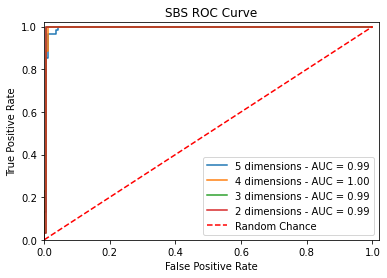

In [51]:
x_train,x_test,y_train,y_test = train_test_split(std_data,labels,test_size = 0.25, random_state = 10)


for k in range(5,1,-1):
    k_str = str(k) + ' dimensions'
    if k == 5:
        lr_sb = LogisticRegression()
        lr_sb.fit(x_train,y_train)
        prediction = lr_sb.predict(x_test)
        #find scores which will be used for roc curve
        lr_scores_sbs = lr_sb.predict_proba(x_test)
        #find tpr & fpr 
        fpr_sbs, tpr_sbs, threshold = roc_curve(y_test, lr_scores_sbs[:, 1])
        #find the area under the curve
        roc_auc = auc(fpr_sbs, tpr_sbs)
        #plot the roc curve
        plt.plot(fpr_sbs, tpr_sbs, label = k_str + ' - AUC = %0.2f' % roc_auc)
    else:
        #create a list to save the errors obtained wen eac of the features are removed
        errors_per_col_index_removed = []
        #find the no of columns
        cols = x_train.shape[1]
        #loop through each of the columns, for each loop,drop the column and find the resulting error
        for i in range(cols):
            fit_data = x_train.drop(x_train.columns[i],axis = 1)
            test_data = x_test.drop(x_test.columns[i],axis = 1)
            lr_sb = LogisticRegression()
            lr_sb.fit(fit_data,y_train)
            predicted_labels = lr_sb.predict(test_data)
            error = sum(abs(predicted_labels - y_test))
            errors_per_col_index_removed.append(error)
        #find the col index with the lowest error when removed
        worst_index = errors_per_col_index_removed.index(min(errors_per_col_index_removed))
        #remove the worst feature
        x_train = x_train.drop(x_train.columns[worst_index],axis = 1)
        x_test = x_test.drop(x_test.columns[worst_index],axis = 1)
        lr_sb = LogisticRegression()
        lr_sb.fit(x_train,y_train)
        prediction = lr_sb.predict(x_test)
        #find scores which will be used for roc curve
        lr_scores_sbs = lr_sb.predict_proba(x_test) 
        #find tpr & fpr 
        fpr_sbs, tpr_sbs, threshold = roc_curve(y_test, lr_scores_sbs[:, 1])
        #find the area under the curve
        roc_auc = auc(fpr_sbs, tpr_sbs)
        #plot the roc curve
        plt.plot(fpr_sbs, tpr_sbs, label = k_str + ' - AUC = %0.2f' % roc_auc)

        #k = k-1
plt.plot([0, 1], [0, 1],'r--', label = 'Random Chance')
plt.title('SBS ROC Curve')
plt.legend(loc = 'lower right')
plt.xlim([0, 1.02])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
        




Comparing both ROC curves, We can see that the performance of the model reduced when the dimesionality was reduced to 2 with PCA while the performance remained pretty much the same when the dimensions were reduced with the sequential backward search algorithm.

We can infer from this experiment, that Sequential backward search algorithm gives better results. However, since the computational time for the sbs algorithm is way more than that of PCA, there might be a tradeoff between performance &amp; computational time.